#  Gaussian Processes for Time Series Forecasting with PyMC3

In this notebook we translate the forecasting models developed for the post on [Gaussian Processes for Time Series Forecasting with Scikit-Learn](https://juanitorduz.github.io/gaussian_process_time_series) to the probabilistic Bayesian framework [PyMC3](https://docs.pymc.io/). I strongly recommend looking into the following references for more details and 
examples:

**References:**
- [An Introduction to Gaussian Process Regression](https://juanitorduz.github.io/gaussian_process_reg/)
- [PyMC3 Docs: Gaussian Processes](https://docs.pymc.io/Gaussian_Processes.html)
- [Example: CO2 at Mauna Loa](https://docs.pymc.io/notebooks/GP-MaunaLoa.html)
- [PyMC3 Docs Example: Bayesian Analysis with Python (Second edition) - Chapter 7](https://github.com/aloctavodia/BAP/blob/master/code/Chp7/07_Gaussian%20process.ipynb)
- [Statistical Rethinking - Chapter 14](https://xcelab.net/rm/statistical-rethinking/)

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

import pymc3 as pm
import arviz as az

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Generate Sample Data

Instead of the step-by-step approach we took in [Gaussian Processes for Time sSeries Forecasting with Scikit-Learn](https://juanitorduz.github.io/gaussian_process_time_series), we are just going to develop one model. 

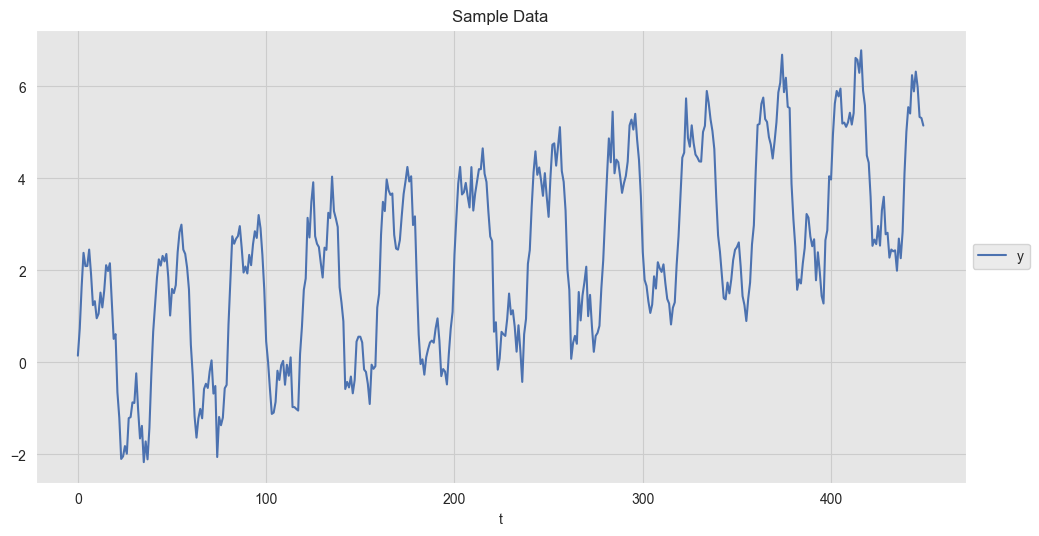

In [2]:
np.random.seed(42)

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi*t)/period) 

def generate_data(n, sigma_n = 0.3):
    """Generate sample data. 
    Two seasonal components, one linear trend and gaussian noise.
    """
    # Define "time" variable.
    t = np.arange(n)
    data_df = pd.DataFrame({'t' : t})
    # Add components:
    data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
    data_df['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40)) 
    data_df['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=13.3)) 
    data_df['tr1'] = 0.01 * data_df['t']
    return data_df.eval('y = s1 + s2 + tr1 + epsilon')


# Number of samples.
n = 450
# Generate data.
data_df = generate_data(n=n)
# Plot. 
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y', data=data_df, color=sns_c[0], label='y', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data', xlabel='t', ylabel='');

## Train-Test Split

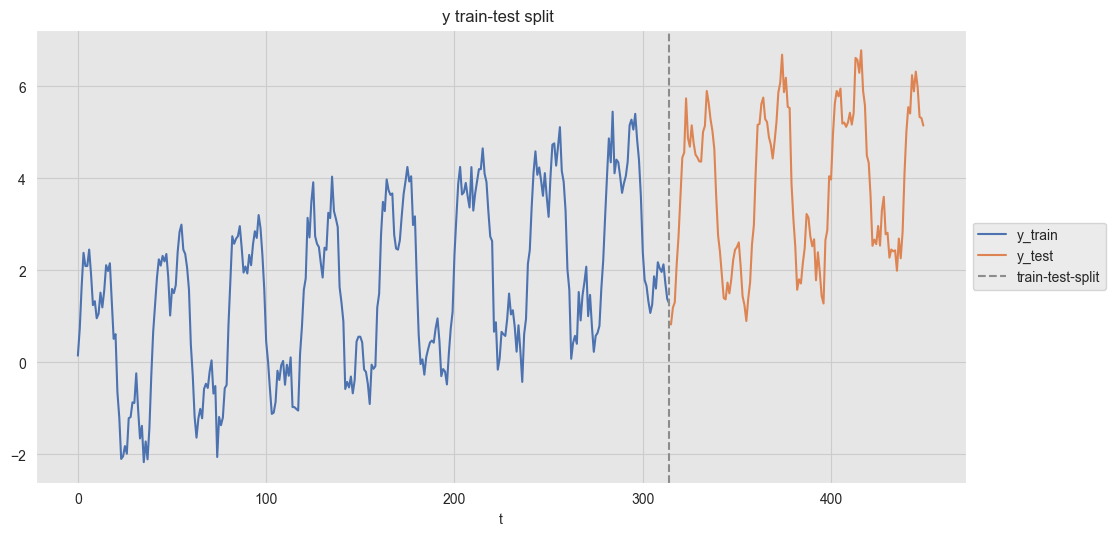

In [3]:
x = data_df['t'].values.reshape(n, 1)
y = data_df['y'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');

## Define Model

Given the structure of the time series we define the model as a gaussian proces with a kernel of the form $k = k_1 + k_2 + k_3$ where $k_1$ and $k_2$ are preriodic kernels and $k_3$ is a linear kernel. For more information about available kernels, please refer to the [covariance functions documentation](https://docs.pymc.io/api/gp/cov.html).

In [4]:
with pm.Model() as model:

    # First seasonal component.
    ls_1 = pm.Gamma(name='ls_1', alpha=2.0, beta=1.0)
    period_1 = pm.Gamma(name='period_1', alpha=80, beta=2)
    gp_1 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_1, ls=ls_1))
    # Second seasonal component.
    ls_2 = pm.Gamma(name='ls_2', alpha=2.0, beta=1.0)
    period_2 = pm.Gamma(name='period_2', alpha=30, beta=2)
    gp_2 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_2, ls=ls_2))
    # Linear trend.
    c_3 = pm.Normal(name='c_3', mu=1, sigma=2)
    gp_3 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c_3))
    # Define gaussian process.
    gp = gp_1 + gp_2 + gp_3
    # Noise.
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    # Likelihood.
    y_pred = gp.marginal_likelihood('y_pred', X=x_train, y=y_train.flatten(), noise=sigma)
    # Sample.
    trace = pm.sample(draws=2000, chains=3, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, c_3, period_2, ls_2, period_1, ls_1]


Sampling 3 chains for 500 tune and 2_000 draw iterations (1_500 + 6_000 draws total) took 1545 seconds.
The acceptance probability does not match the target. It is 0.9558359072560835, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932482306590168, but should be close to 0.8. Try to increase the number of tuning steps.


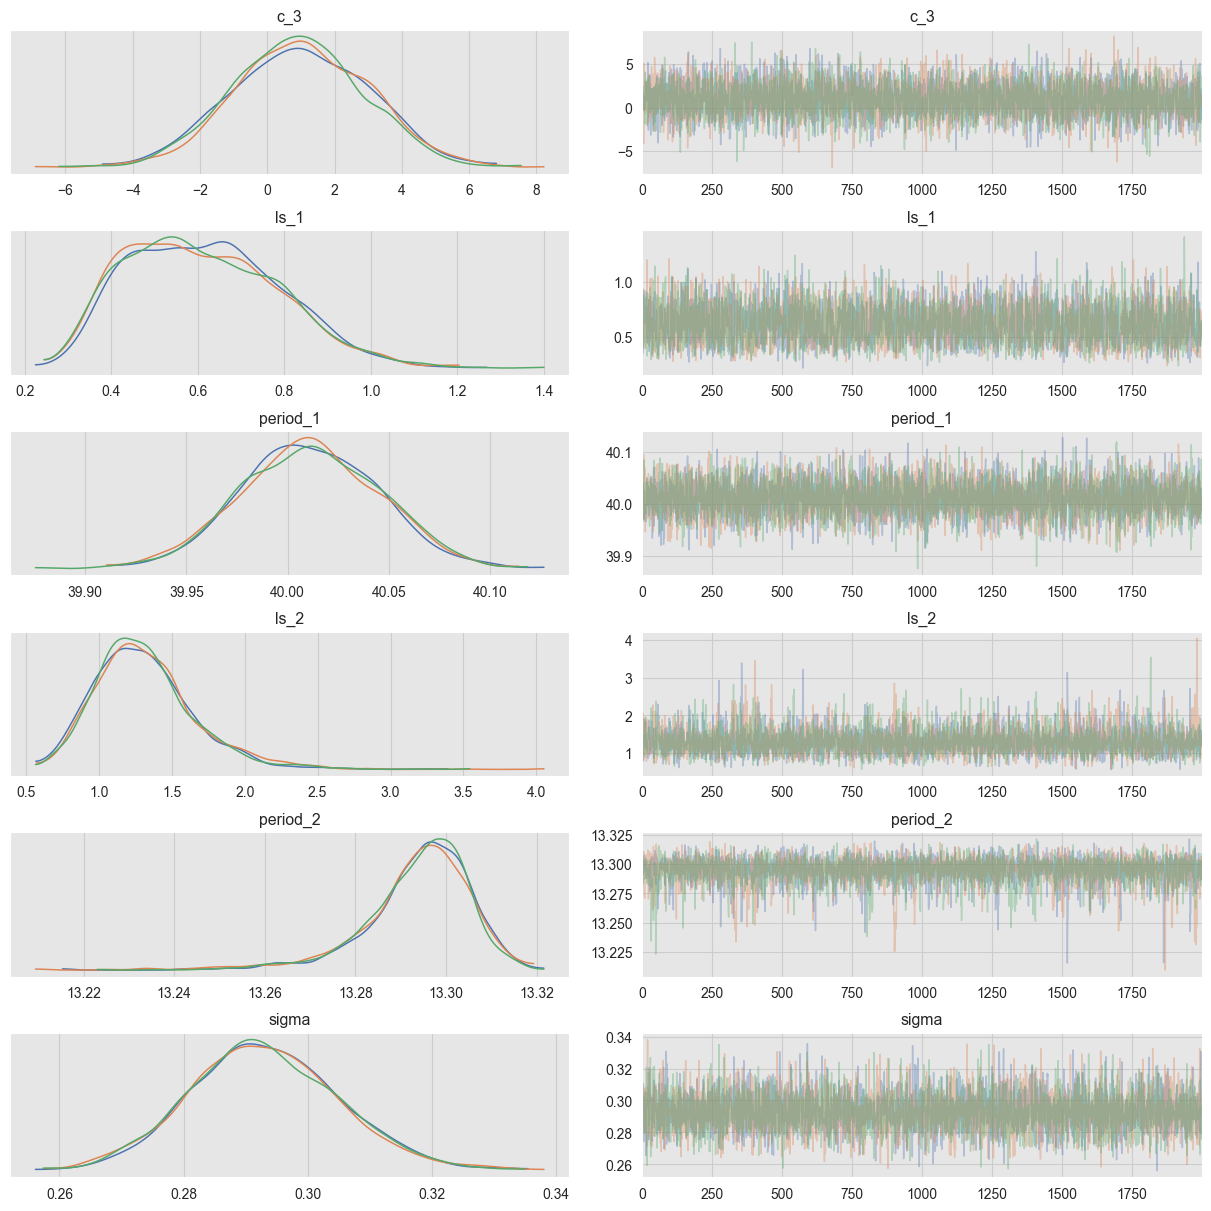

In [5]:
# Plot parameters posterior distribution.
az.plot_trace(trace);

In [6]:
# Get model summary.
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
c_3,0.986,1.989,-2.706,4.664,0.024,0.023,7115.0,3598.0,7127.0,4753.0,1.0
ls_1,0.612,0.173,0.324,0.927,0.003,0.002,3507.0,3507.0,3156.0,2888.0,1.0
period_1,40.011,0.034,39.948,40.074,0.000,0.000,6913.0,6913.0,6921.0,4013.0,1.0
ls_2,1.313,0.346,0.724,1.961,0.006,0.005,3489.0,2955.0,4239.0,2838.0,1.0
period_2,13.294,0.012,13.273,13.314,0.000,0.000,1958.0,1958.0,2885.0,1807.0,1.0
sigma,0.293,0.012,0.270,0.315,0.000,0.000,6152.0,6091.0,6228.0,4459.0,1.0


## Generate Predictons

In [7]:
with model:
    
    x_train_conditional = gp.conditional('x_train_conditional', x_train)
    y_train_pred_samples = pm.sample_posterior_predictive(trace, vars=[x_train_conditional], samples=100)

    x_test_conditional = gp.conditional('x_test_conditional', x_test)
    y_test_pred_samples = pm.sample_posterior_predictive(trace, vars=[x_test_conditional], samples=100)

Prediction samples stats:

In [8]:
# Train
y_train_pred_samples_mean = y_train_pred_samples['x_train_conditional'].mean(axis=0)
y_train_pred_samples_std = y_train_pred_samples['x_train_conditional'].std(axis=0)
y_train_pred_samples_mean_plus = y_train_pred_samples_mean + 2*y_train_pred_samples_std
y_train_pred_samples_mean_minus = y_train_pred_samples_mean - 2*y_train_pred_samples_std
# Test
y_test_pred_samples_mean = y_test_pred_samples['x_test_conditional'].mean(axis=0)
y_test_pred_samples_std = y_test_pred_samples['x_test_conditional'].std(axis=0)
y_test_pred_samples_mean_plus = y_test_pred_samples_mean + 2*y_test_pred_samples_std
y_test_pred_samples_mean_minus = y_test_pred_samples_mean - 2*y_test_pred_samples_std

Plot predictons:

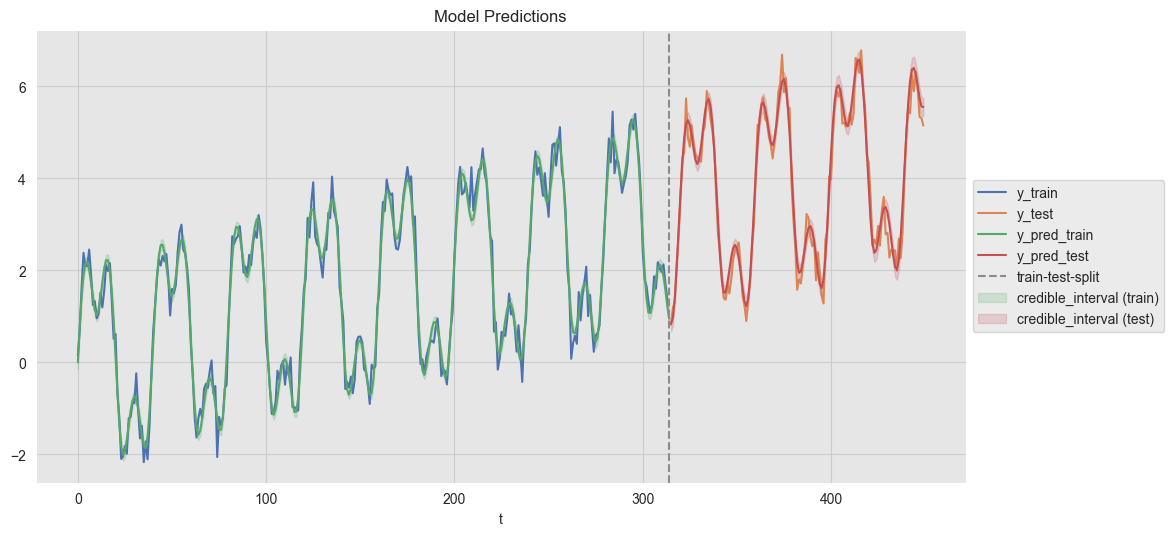

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.fill_between(
    x=x_train.flatten(), 
    y1=y_train_pred_samples_mean_minus, 
    y2=y_train_pred_samples_mean_plus, 
    color=sns_c[2], 
    alpha=0.2, 
    label='credible_interval (train)'
)
sns.lineplot(x=x_train.flatten(), y=y_train_pred_samples_mean, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=x_test.flatten(), 
    y1=y_test_pred_samples_mean_minus, 
    y2=y_test_pred_samples_mean_plus, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=x_test.flatten(), y=y_test_pred_samples_mean, color=sns_c[3], label='y_pred_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='t', ylabel='');